In [291]:
#IMPORTS
import string
from collections import Counter
import datetime as dt
from numpy import array
import numpy as np
import pickle
from pickle import load, dump
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#EXTRACTING TEXT DATA AND PREPROCESSING
#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filepath, 'r')
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
tokens_dic = {}
for line in lines:
    tokens = line.split()
    image_ = tokens[0]
    caption = ' '.join(tokens[1:])
    image_title = image_.split('.')[0]
    if(image_title not in tokens_dic.keys()):
        tokens_dic[image_title] = [caption]
    else:
        tokens_dic[image_title].append(caption)


#STEP: PREPROCESSING
table = str.maketrans('', '', string.punctuation)
for captions in tokens_dic.values():
    for i in range(len(captions)):
        caption = captions[i]
        words = caption.split()
        words = [word.lower() for word in words]
        words = [word.translate(table) for word in words]
        words = [word for word in words if len(word)>1]
        words = [word for word in words if word.isalpha()]
        captions[i] = ' '.join(words)

In [4]:
#LOADING TRAINING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
train = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    train.append(image_title)
#NOTE: SIZE OF TRAIN LIST IS 6000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
train_dataset = {}
max_caption_length = 0
for image_title, captions in tokens_dic.items():
    if(image_title in train and (image_title not in train_dataset.keys())):
        train_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            train_dataset[image_title].append(refined_caption)
            max_caption_length = max(max_caption_length, len(refined_caption.split()))
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [314]:
#LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
dev = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    dev.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
dev_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in dev and (image_title not in dev_dataset.keys())):
        dev_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            dev_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF DEV DATASET IS 1000

In [5]:
#LOADING TESTING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
test = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    test.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
test_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in test and (image_title not in test_dataset.keys())):
        test_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            test_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF TEST DATASET IS 1000

In [6]:
#CONSTRUCTING VOCABULARY FROM CAPTIONS
vocabulary = set()
for captions in tokens_dic.values():
    for caption in captions:
        for word in caption.split():
            vocabulary.add(word)
#NOTE: SIZE OF VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 8763

#CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS
word_count_threshold = 10
all_train_words = []
for captions in train_dataset.values():
    for caption in captions:
        words = caption.split()
        for word in words:
            all_train_words.append(word)

counter = Counter(all_train_words)
commons = counter.most_common()
most_probable_vocabulary = set()
for ele in commons:
    if(ele[1]>=word_count_threshold):
        most_probable_vocabulary.add(ele[0])
vocabulary_size = len(most_probable_vocabulary)
#NOTE: SIZE OF MOST PROBABLE VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 1651

In [7]:
#TO GET INPUT VECTOR X FROM IMAGES WE USE TRANSFER LEARNING THROUGH INCEPTIONV3 MODEL TRAINED ON 1000 DIFFERENT CLASSES OF IMAGES
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)
encoded_train_images = {}
start = dt.datetime.now()
i = 0
for image_title in train_dataset.keys():
    image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+image_title+".jpg"
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    encoded_train_images[image_title] = feature_vec
    present = dt.datetime.now()
    if((i/500).is_integer()):
        print("{}th ITERATION".format(i))
        print("TIME SO FAR: {}s".format((present-start).total_seconds()))
    i+=1
end = dt.datetime.now()
print("TIME TAKEN TO ENCODE TRAIN IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end-start).total_seconds()))

0th ITERATION
TIME SO FAR: 4.357329s
500th ITERATION
TIME SO FAR: 104.253102s
1000th ITERATION
TIME SO FAR: 203.841536s
1500th ITERATION
TIME SO FAR: 327.538582s
2000th ITERATION
TIME SO FAR: 421.301079s
2500th ITERATION
TIME SO FAR: 513.465127s
3000th ITERATION
TIME SO FAR: 605.739588s
3500th ITERATION
TIME SO FAR: 698.434162s
4000th ITERATION
TIME SO FAR: 791.074074s
4500th ITERATION
TIME SO FAR: 885.560459s
5000th ITERATION
TIME SO FAR: 978.235567s
5500th ITERATION
TIME SO FAR: 1071.538087s
TIME TAKEN TO ENCODE TRAIN IMAGES INTO 2048 LENGTH FEATURE VECTOR: 1164.811601s


In [315]:
#TO GET INPUT VECTOR X FROM IMAGES WE USE TRANSFER LEARNING THROUGH INCEPTIONV3 MODEL TRAINED ON 1000 DIFFERENT CLASSES OF IMAGES
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)
encoded_dev_images = {}
start = dt.datetime.now()
i = 0
for image_title in dev_dataset.keys():
    image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+image_title+".jpg"
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    encoded_dev_images[image_title] = feature_vec
    present = dt.datetime.now()
    if((i/500).is_integer()):
        print("{}th ITERATION".format(i))
        print("TIME SO FAR: {}s".format((present-start).total_seconds()))
    i+=1
end = dt.datetime.now()
print("TIME TAKEN TO ENCODE DEV IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end-start).total_seconds()))

0th ITERATION
TIME SO FAR: 4.028576s
500th ITERATION
TIME SO FAR: 104.491151s
TIME TAKEN TO ENCODE DEV IMAGES INTO 2048 LENGTH FEATURE VECTOR: 209.668s


In [8]:
#TO GET INPUT VECTOR X FROM IMAGES WE USE TRANSFER LEARNING THROUGH INCEPTIONV3 MODEL TRAINED ON 1000 DIFFERENT CLASSES OF IMAGES
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)
encoded_test_images = {}
start = dt.datetime.now()
i = 0
for image_title in test_dataset.keys():
    image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+image_title+".jpg"
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    encoded_test_images[image_title] = feature_vec
    present = dt.datetime.now()
    if((i/500).is_integer()):
        print("{}th ITERATION".format(i))
        print("TIME SO FAR: {}s".format((present-start).total_seconds()))
    i+=1
end = dt.datetime.now()
print("TIME TAKEN TO ENCODE TEST IMAGES INTO 2048 LENGTH FEATURE VECTOR: {}s".format((end-start).total_seconds()))

0th ITERATION
TIME SO FAR: 3.734712s
500th ITERATION
TIME SO FAR: 96.06271s
TIME TAKEN TO ENCODE TEST IMAGES INTO 2048 LENGTH FEATURE VECTOR: 189.069741s


In [316]:
#WRITING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES TO PKL FILES
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train_images, encoded_pickle)
    
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_test_images, encoded_pickle)
    
with open("encoded_dev_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_dev_images, encoded_pickle)

In [581]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocabulary_size+1)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [12]:
#USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
index = 1
for word in most_probable_vocabulary:
    index_to_word[index] = word
    word_to_index[word] = index
    index+=1

In [13]:
#WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
file = open("../../../Downloads/glove/glove.6B.200d.txt", "r")
content = file.read()
file.close()
lines = content.split('\n')
for line in lines:
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype='float32')
    embeddings[word] = vector

In [14]:
#MAPPING MOST PROBABLE VOCABULARY TO VECTOR BY CREATING A DENSE MATRIX WITH ROW AS WORD AND COLUMNS ARE 200 DIMENSIONS OF VECTOR
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size+1, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if(vector is not None):
        embeddings_matrix[index]=vector
#NOTE: DIMENSION OF EMBEDDINGS MATRIX IS (MOST PROBABLE VOCABULARY X 200), HERE (1951 X 200)
#NOTE: 1ST ROW OF EMBEDDINGS MATRIX IS ALL ZEROS

In [320]:
#DEFINING THE LAYERS OF THE MODEL
input1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocabulary_size+1, embedding_dim, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

output = Dense(vocabulary_size+1, activation='softmax')(decoder2)
model = Model(inputs=[input1, input2], outputs=output)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 200)      330400      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [321]:
#SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER I.E. NO TRAINING ON EMBEDDINGS LAYER
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False

#COMPILING THE MODEL
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
#HYPERPARAMETERS OF TRAINING SESSION 1
#NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [22]:
#TRAINING SESSION 1
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 786s 393ms/step - loss: 4.1130
Epoch 1/1
2000/2000 [==============================] - 756s 378ms/step - loss: 3.4171
Epoch 1/1
2000/2000 [==============================] - 790s 395ms/step - loss: 3.1954
Epoch 1/1
2000/2000 [==============================] - 777s 389ms/step - loss: 3.0627
Epoch 1/1
2000/2000 [==============================] - 764s 382ms/step - loss: 2.9668
Epoch 1/1
2000/2000 [==============================] - 848s 424ms/step - loss: 2.8935
Epoch 1/1
2000/2000 [==============================] - 746s 373ms/step - loss: 2.8337
Epoch 1/1
2000/2000 [==============================] - 794s 397ms/step - loss: 2.7865
Epoch 1/1
2000/2000 [==============================] - 740s 370ms/step - loss: 2.7459
Epoch 1/1
2000/2000 [==============================] - 775s 388ms/step - loss: 2.7105
Epoch 1/1
2000/2000 [==============================] - 755s 377ms/step - loss: 2.6794
Epoch 1/1
2000/2000 [==============================] -

In [23]:
#HYPERPARAMETERS OF TRAINING SESSION 2
#NOTE: LEARNING RATE IS CHANGED TO 0.0001
K.set_value(model.optimizer.lr, 0.0001)
epochs = 10
batch_size = 6
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [24]:
#TRAINING SESSION 2
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i+20) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 612s 612ms/step - loss: 2.5009
Epoch 1/1
1000/1000 [==============================] - 617s 617ms/step - loss: 2.4458
Epoch 1/1
1000/1000 [==============================] - 618s 618ms/step - loss: 2.4252
Epoch 1/1
1000/1000 [==============================] - 672s 672ms/step - loss: 2.4143
Epoch 1/1
1000/1000 [==============================] - 704s 704ms/step - loss: 2.4037
Epoch 1/1
1000/1000 [==============================] - 627s 627ms/step - loss: 2.3936
Epoch 1/1
1000/1000 [==============================] - 595s 595ms/step - loss: 2.3853
Epoch 1/1
1000/1000 [==============================] - 596s 596ms/step - loss: 2.3797
Epoch 1/1
1000/1000 [==============================] - 606s 606ms/step - loss: 2.3718
Epoch 1/1
1000/1000 [==============================] - 603s 603ms/step - loss: 2.3664


In [322]:
#LOADING TRAINED WEIGHTS TO MODEL
model.load_weights('./model_weights/model_29.h5')

In [188]:
def predict(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen=max_caption_length)
        yhat = model.predict([feature_vec,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        partial_caption += ' ' + word
        if word == 'endseq':
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

model
263850317_5bb3a18a08


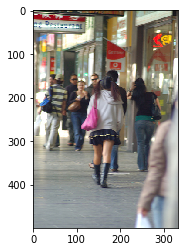

prediction: woman in skimpy and heels walks down the street
Ground Truth: an asian girl carrying pink bag is walking away down busy city street
Ground Truth: woman wearing black boots and skirt walks down the sidewalk
Ground Truth: woman with pink purse walks down crowded sidewalk
Ground Truth: young woman in black skirt and boots walks by stores
Ground Truth: girl wearing mini dress and long sleve white jacket with pink bag walking through crowded area


In [577]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM TEST DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("model")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 2048))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

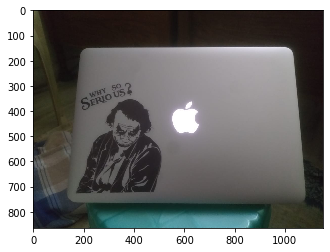

prediction: man is sitting on bench with his dog


In [576]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

image_path = "../../../Downloads/laptop_test.jpeg"
feature_vec = image_to_feature_vec(image_path)
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict(feature_vec)))

In [353]:
#PERFORMANCE ON TRAIN DATASET, DEV DATASET
batch_size = 3
steps = len(train_dataset)//batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = model.evaluate(train_generator, steps=steps, verbose=0)

batch_size = 4
steps = len(dev_dataset)//batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = model.evaluate(dev_generator, steps=steps, verbose=0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

LOSS ON TRAIN DATASET: 2.369915008544922
LOSS ON DEV DATASET: 3.4760239124298096


In [361]:
#CHANGING THE MODEL ARCHITECHTURE TO ACCOUNT FOR UNDERFITTING I.E. INCREASING MORE LAYERS
input1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(512, activation='relu')(fe1)
fe3 = Dense(256, activation='relu')(fe2)

input2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocabulary_size+1, embedding_dim, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)
se4 = Dense(256)(se3)

decoder1 = add([fe3, se4])
decoder2 = Dense(256, activation='relu')(decoder1)

output = Dense(vocabulary_size+1, activation='softmax')(decoder2)
model2 = Model(inputs=[input1, input2], outputs=output, name="model2")

model2.summary()

Model: "model2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 34, 200)      330400      input_17[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 2048)         0           input_16[0][0]                   
_____________________________________________________________________________________________

In [362]:
#SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER I.E. NO TRAINING ON EMBEDDINGS LAYER
model2.layers[2].set_weights([embeddings_matrix])
model2.layers[2].trainable = False

#COMPILING THE MODEL
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [363]:
#HYPERPARAMETERS OF TRAINING SESSION 1
#NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [364]:
#TRAINING SESSION 1
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model2.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model2.save('./model2_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1680s 840ms/step - loss: 4.0417
Epoch 1/1
2000/2000 [==============================] - 1740s 870ms/step - loss: 3.3753
Epoch 1/1
2000/2000 [==============================] - 1625s 813ms/step - loss: 3.1593
Epoch 1/1
2000/2000 [==============================] - 1682s 841ms/step - loss: 3.0169
Epoch 1/1
2000/2000 [==============================] - 1847s 923ms/step - loss: 2.9140
Epoch 1/1
2000/2000 [==============================] - 1751s 876ms/step - loss: 2.8269
Epoch 1/1
2000/2000 [==============================] - 1660s 830ms/step - loss: 2.7587
Epoch 1/1
2000/2000 [==============================] - 1653s 827ms/step - loss: 2.7045
Epoch 1/1
2000/2000 [==============================] - 1663s 831ms/step - loss: 2.6528
Epoch 1/1
2000/2000 [==============================] - 1646s 823ms/step - loss: 2.6128
Epoch 1/1
2000/2000 [==============================] - 1643s 821ms/step - loss: 2.5737
Epoch 1/1
2000/2000 [======================

In [365]:
#HYPERPARAMETERS OF TRAINING SESSION 2
#NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(model2.optimizer.lr, 0.0003)
epochs = 5
batch_size = 6
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [368]:
#TRAINING SESSION 2
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model2.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model2.save('./model2_weights/model_' + str(i+20) + '.h5')

Epoch 1/1
600/600 [==============================] - 1375s 2s/step - loss: 2.1769
Epoch 1/1
600/600 [==============================] - 1373s 2s/step - loss: 2.1528
Epoch 1/1
600/600 [==============================] - 1393s 2s/step - loss: 2.1427
Epoch 1/1
600/600 [==============================] - 1401s 2s/step - loss: 2.1328
Epoch 1/1
600/600 [==============================] - 1404s 2s/step - loss: 2.1271


In [372]:
#HYPERPARAMETERS OF TRAINING SESSION 3
#NOTE: LEARNING RATE IS CHANGED TO 0.00001
K.set_value(model2.optimizer.lr, 0.00001)
epochs = 5
batch_size = 15
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [373]:
#TRAINING SESSION 3
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    model2.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model2.save('./model2_weights/model_' + str(i+25) + '.h5')

Epoch 1/1
400/400 [==============================] - 1380s 3s/step - loss: 2.1267
Epoch 1/1
400/400 [==============================] - 1368s 3s/step - loss: 2.1236
Epoch 1/1
400/400 [==============================] - 1308s 3s/step - loss: 2.1214
Epoch 1/1
400/400 [==============================] - 1310s 3s/step - loss: 2.1166
Epoch 1/1
400/400 [==============================] - 1305s 3s/step - loss: 2.1181


In [374]:
#LOADING TRAINED WEIGHTS TO MODEL
model2.load_weights('./model2_weights/model_29.h5')

In [375]:
def predict2(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen=max_caption_length)
        yhat = model2.predict([feature_vec,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        partial_caption += ' ' + word
        if word == 'endseq':
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

model1
3158327361_6f1a518228


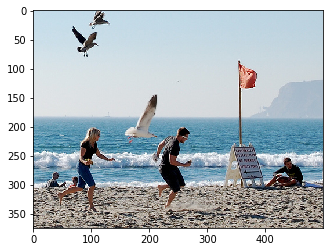

prediction: two people are standing on the edge of body of water and looking at something in the distance
Ground Truth: couple of people running on the shore near the beach
Ground Truth: man and woman hopping acrouss hot sand
Ground Truth: people running away from seagulls on the beach
Ground Truth: two people run in the sand at the beach
Ground Truth: two people run along beach with seagulls


In [579]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("model1")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 2048))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict2(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

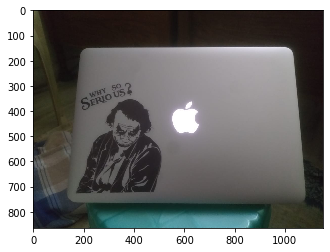

prediction: man in blue shirt is sitting on stool with his head resting on his head


In [580]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES INPUT FROM LOCAL MACHINE
def image_to_feature_vec(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature_vec = model_new.predict(x)
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec.reshape((1, 2048))

image_path = "../../../Downloads/laptop_test.jpeg"
feature_vec = image_to_feature_vec(image_path)
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict2(feature_vec)))

In [411]:
#PERFORMANCE ON TRAIN DATASET, DEV DATASET
batch_size = 3
steps = len(train_dataset)//batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = model2.evaluate(train_generator, steps=steps, verbose=0)

batch_size = 4
steps = len(dev_dataset)//batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = model2.evaluate(dev_generator, steps=steps, verbose=0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

LOSS ON TRAIN DATASET: 2.0370585918426514
LOSS ON DEV DATASET: 3.815887928009033
